# Project

## Dependencies

In [1]:
#%pip install --quiet --upgrade --pre mesa[rec] #install Mesa 3.0 

In [2]:
#%pip install solara


In [3]:
import mesa
import time
# Data visualization tools.
import seaborn as sns
import random
import numpy as np

# Data manipulation and analysis.
import pandas as pd


In [4]:
print(f"Mesa version: {mesa.__version__}")
from mesa.visualization.utils import update_counter
from mesa.visualization import SolaraViz, make_plot_component, make_space_component
from mesa.datacollection import DataCollector

Mesa version: 3.1.0.dev


## Traffic Model

In [5]:
class TrafficModel(mesa.Model):
    def __init__(self, width=24, height=24, num_agents=1,
                 left_coords=None, right_coords=None, up_coords=None, down_coords=None):
        super().__init__()
        self.width = width
        self.height = height
        self.num_agents = num_agents
        self.grid = mesa.space.MultiGrid(width, height, True)
        self.random = random.Random()
        self.steps = 0
        self.sema_coords = [[(8,22),(8,23)], [(8,18),(8,17)], [(6,21),(7,21)], [(6,16),(7,16)], [(6,2),(7,2)], [(0,6),(1,6)], [(2,4),(2,5)], [(5,0),(5,1)], [(17,8),(17,9)], [(18,7),(19,7)]]

        self.ParkingSpots = {
             1 : (2,14),   2 : (3,21),   3 : (3,6),
             4 : (4,12),   5 : (4,3),    6 : (5,17),
             7 : (8,15),   8 : (9,2),   9 : (10,19),
            10 : (10,12), 11 : (10,7),  12: (17,12),
            13 : (17,6),  14 : (17,4),  15: (20,18),
            16 : (20,15), 17 : (20,4)
        }
        # Dictionary to store directions for each cell
        self.directions = {}    

        # Crear agentes y colocarlos en el grid
        used_parking_spots = set()

        for i in range(num_agents):

            available_spawn_spots = [spot for spot in self.ParkingSpots.values() if spot not in used_parking_spots]

            if available_spawn_spots:
                Spawn = random.choice(available_spawn_spots)
            else:
                # Si no hay spots disponibles, puedes tomar alguna acción (puedes hacer un break o algo similar)
                print("No available spots for spawn")
                break 

            used_parking_spots.add(Spawn)

            # Crear una lista de spots disponibles para el parking objetivo (que no sean el de Spawn ni los usados)
            available_target_spots = [spot for spot in self.ParkingSpots.values() if spot != Spawn and spot not in used_parking_spots]

            if available_target_spots:
                target_parking_spot = random.choice(available_target_spots)
            else:
                # Si no hay spots disponibles, tomar alguna acción (ej. break o continuar)
                print("No available spots for target parking")
                break  # o continuar con alguna otra acción que desees.

            # Marcar el spot objetivo como utilizado
            used_parking_spots.add(target_parking_spot)
            
            print(f"Spawn: ({Spawn}), Target: ({target_parking_spot})")

            agent = CarAgent(self, Spawn, target_parking_spot)  # Pasa las coordenadas desglosadas

            # Colocar el agente en la celda 'Spawn' usando las coordenadas correctas
            self.grid.place_agent(agent, Spawn)
                
            
            
            
        # Inicializar las direcciones permitidas para cada celda
        self.initialize_directions(left_coords, right_coords, up_coords, down_coords)

        # Colocar los semáforos en el grid
        self.place_semaphore_agents()
        
        # Place EdifAgents in cells where all directions are False
        self.place_edif_agents()
        
        # Initialize the DataCollector
        self.datacollector = mesa.DataCollector(
            model_reporters={
                "NumAgents": "num_agents",
            },
            agent_reporters={
                "Position": "pos",
                "TargetParkingSpot": lambda agent: agent.target_parking_spot if isinstance(agent, CarAgent) else None
            }
        )

     
        # Collect initial data
        self.datacollector.collect(self)

    def initialize_directions(self, left_coords, right_coords, up_coords, down_coords):
        # Inicializar todas las coordenadas del grid con todas las direcciones en False
        for x in range(self.width):
            for y in range(self.height):
                self.directions[(x, y)] = {
                    "left": False,
                    "right": False,
                    "up": False,
                    "down": False
                }

        # Configurar direcciones específicas para cada lista
        for coord in left_coords:
            if coord in self.directions:
                self.directions[coord]["left"] = True

        for coord in right_coords:
            if coord in self.directions:
                self.directions[coord]["right"] = True

        for coord in up_coords:
            if coord in self.directions:
                self.directions[coord]["up"] = True

        for coord in down_coords:
            if coord in self.directions:
                self.directions[coord]["down"] = True



    def get_cell_directions(self, pos):
        # Fetch the direction info for a specific cell
        return self.directions.get(pos, None)
    
    def step(self):
        self.agents.shuffle_do("step")
        self.datacollector.collect(self)
    # 


    def place_edif_agents(self):
        # Place EdifAgents in cells where all directions are False
        for pos, directions in self.directions.items():
            if not any(directions.values()):  # All directions are False
                edif_agent = EdifAgent(self)
                self.grid.place_agent(edif_agent, pos)

    def place_semaphore_agents(self):
        # Iterar sobre cada semáforo en sema_coords y asignar un ID único para cada par
        for idx, semaforo in enumerate(self.sema_coords):
            semaforo_id = f"sema_{idx}"  # ID único para cada semáforo
            
            # Crear dos agentes separados con el mismo id y colocarlos en las posiciones correspondientes
            for pos in semaforo:
                sema_agent = SemaphoreAgent(semaforo_id, self)  # Asigna el mismo id
                self.grid.place_agent(sema_agent, pos)
        
    


## Car Agent
Main points of the agent's functionality:

- Initialization:
Each agent has a unique ID and is created with the model. 
It is randomly positioned on the model's grid.
- Movement:
The main movement method is `move()`.
This method is called at each model step `step()`.
- Directions:
A dictionary of directions is used: "up," "down," "left," "right".
- Choosing a random direction:
A random direction is selected from those allowed in the current cell.
- Checking for an empty space:
Before moving, it checks if the new space is empty.

**Basic Configuration:**
- Defines the width and height of the grid (default is 24x24). 
Sets the number of agents (default is 10).
- Path Customization:
Allows defining custom paths using lists of coordinates (x, y) for each direction (up, down, left, right).
- Model Initialization: 
Creates a two-dimensional grid (MultiGrid). 
Initializes the scheduler to manage model steps.
- Agent Creation: 
Randomly places agents on the grid.
- Direction Initialization: 
Uses the initialize_directions() method to set up allowed directions in each cell based on the provided lists.
- Model Steps: The step() method is called at each step to update the state of all agents.

In [6]:
class CarAgent(mesa.Agent):
    def __init__(self, model, spawn_position, target_parking_spot):
        super().__init__(model)
        self.distance_travelled = 0
        self.target_parking_spot = random.choice(list(model.ParkingSpots.values()))

    def check_semaphore(self, current_position): #for future implementation, check if the agent is a car
        agents_at_position = self.model.grid.get_cell_list_contents([current_position])
        semaphore_agent = None
        for agent in agents_at_position:
            if agent.__class__ == SemaphoreAgent:
                semaphore_agent = agent
        if semaphore_agent is None:
            return True
        else:
            if semaphore_agent.state == "red":
                print(f"Semaphore at {current_position} is red; agent cannot move.")
                return False
            elif semaphore_agent.state == "green":
                print(f"Semaphore at {current_position} is green; agent can move.")
                return True

    def move(self):
# Get current position and allowed directions
        current_position = self.pos
        possible_current_directions = self.model.get_cell_directions(current_position)
        
        # Check for any available directions in this cell
        if not possible_current_directions:
            print(f"No directions available for agent at position {current_position}")
            return

        # Filter allowed directions and select one randomly
        possible_directions = [direction for direction, allowed in possible_current_directions.items() if allowed]
        if not possible_directions:
            print(f"No movement options for agent at position {current_position}")
            return

        # Checks if it can move acccording to the sempahore
        if not self.check_semaphore(current_position):
            return 

        direction = random.choice(possible_directions)

        # Calculate the new position based on the chosen direction
        dx, dy = {
            "up": (0, 1),
            "down": (0, -1),
            "left": (-1, 0),
            "right": (1, 0)
        }[direction]

        new_position = (self.pos[0] + dx, self.pos[1] + dy)
       

        # Check if the new position Has another car PENDING
        
        self.model.grid.move_agent(self, new_position)
        self.distance_travelled += 1  # Increment distance traveled
        self.pos = new_position       # Update the position
        print(f"Agent moved to {self.pos}")
        print(f"Position {new_position} is occupied; agent cannot move there.")
            
    def move_to_target(self):
        # Moverse hasta alcanzar el destino
        while self.pos != self.target_parking_spot:
            moved = self.move()
            if not moved:  # Si no puede moverse, detener el bucle
                print(f"Agent {self.unique_id} is stuck and cannot reach the target.")
                break            
            
    def step(self):
        self.move()

## EdifAgent basic

Este agente nos servira solamente para pintar los edificios

In [7]:
class EdifAgent(mesa.Agent):
    def __init__(self,model):
        super().__init__(model)


## Semaphore Agent

In [8]:
sema_coords = [[(8,22),(8,23)], [(8,18),(8,17)], [(6,21),(7,21)], [(6,16),(7,16)], [(6,2),(7,2)], [(0,6),(1,6)], [(2,4),(2,5)], [(5,0),(5,1)], [(17,8),(17,9)], [(18,7),(19,7)]]

In [ ]:
class SemaphoreAgent(mesa.Agent):
    def __init__(self, id, model):
        super().__init__(model)
        self.id = id
        self.state = "red"
        self.time_counter = 0

    def change_state(self):
        self.state = "green" if self.state == "red" else "red"
    
    def step(self):
        self.time_counter += 1
        if self.time_counter >= 5:
            self.change_state()
            self.time_counter = 0

**Left_coords**

- Vuelta 1:
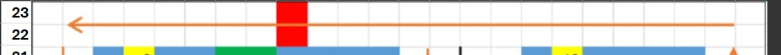

- Vuelta 2
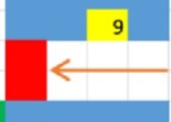

- Vuelta 3
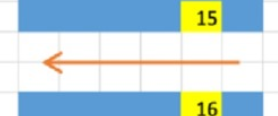

- Vuelta 4
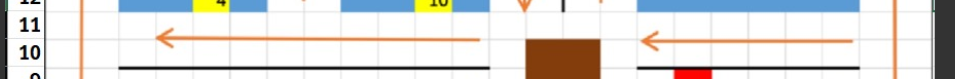


- Vuelta 5
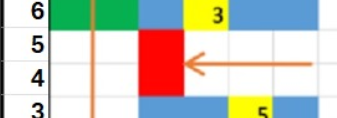

In [10]:
# Lista de coordenadas con flechas hacia la izquierda
left_coords = [
# CALLE LARGA fila 23 y 22 atraviesa MAPA ////////////// VUELTA 1
    # Carril izquierdo p1
    (x, 23) for x in range(1, 24)
] + [
    # Carril derecho p1
    (x, 22) for x in range(1, 24)
] + [

# Calle corta fila 18 y 17 semaforo rojo//////////////// VUELTA 2
    (8, 18), (9, 18), (10, 18), (11, 18), (12, 18),
    (8, 17), (9, 17), (10, 17), (11, 17), (12, 17)
] + [

# Calle corta fila 5 y 4 semaforo rojo////////////////// VUELTA 5
    (2, 5), (3, 5), (4, 5), (5, 5),(6, 5),
    (2, 4), (3, 4), (4, 4), (5, 4),(6, 4)

] + [

#  CALLE LARGA fila 11 y 10 atraviesa MAPA////////////// VUELTA 4
    # Carril izquirdo
    (x, 11) for x in range(1, 23)
] + [
    # Carril derecho parte 1
    (x, 10) for x in range(1, 13)
] + [
    # Carril derecho parte 2
    (x, 10) for x in range(16, 23)
]+ [

# Calle corta fila 17 y 16///////////////////////////// VUELTA 3
    # Carril izquierdo
    (x, 17) for x in range(15, 23)
] + [
    # Carril derecho
    (x, 16) for x in range(15, 23)
] + [
    #Parking spot 1
    (2,14)
] + [
    #Parking spot 6
    (6,17)
] + [
    #Parking spot 7
    (8,15)
] + [
    #Parking spot 13
    (18,6)
] + [
    #Parking spot 14
    (18,4)
] + [
    #Parking spot 17
    (20,4)
]

**right_coords**

- Trayecto 1
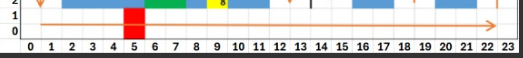








- Trayectoria 2
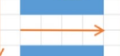





- Trayectoria 3
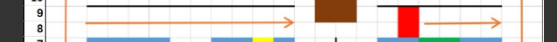

In [11]:
# Lista de coordenadas con flechas hacia la derecha
right_coords = [
# CALLE LARGA fila 23 y 22 atraviesa MAPA ////////////// VUELTA 1
    # Carril izquierdo p1
    (x, 1) for x in range(0, 23)
]+ [
    # Carril derecho p1
    (x, 0) for x in range(0, 23)
] + [


# CALLE CORTA fila 5 y 4 atraviesa MAPA ////////////// VUELTA 2
  # Carril izquierdo p1
    (x, 4) for x in range(7, 12)
] + [
   # Carril derecho p2
    (x, 5) for x in range(7, 12)
] +[


# CALLE CORTA fila 8 y 9 atraviesa MAPA ////////////// VUELTA 3
  # Carril izquierdo p1
    (x, 9) for x in range(1, 12)
] + [
   # Carril izquierdo p3
    (x, 9) for x in range(15, 22)
] + [
   # Carril derecho p1
    (x, 8) for x in range(1, 22)
] + [
    #Parking spot 1
    (1,14)
] + [
    #Parking spot 6
    (5,17)
] + [
    #Parking spot 7
    (7,15)
] + [
    #Parking spot 13
    (17,6)
] + [
    #Parking spot 14
    (17,4)
] + [
    #Parking spot 17
    (19,4)
]

**up_coords**

In [12]:
up_coords = [
# CALLE CORTA fila 6 ////////////// TRAYECTO  1
    # Carril izquierdo
    (6, y) for y in range(12, 22)
] + [
    #Carril derecho
    (7, y) for y in range(12, 22)
] + [
# CALLE LARGA fila 14 atraviesa MAPA ////////////// TRAYECTO  2 **rotonda, cambio de carril
    # Carril izquierdo p1
    (14, y) for y in range(1, 8)
] + [
    # Carril izquierdo p2
    (14, y) for y in range(11, 22)
] + [
    # Carril derecho
    (15, y) for y in range(1, 22)
] + [
#CALLE CORTA fila 18//////////////////////////////////////
    #Carril izquierdo
    (18, y) for y in range(1, 8)
] + [
    #Carril derecho
    (19, y) for y in range(1, 8)
] + [
#CALLE LARGA fila 22//////////////////////////////////////
    #Carril izquierdo
    (22, y) for y in range(1, 22)
] + [
    #Carril derecho
    (23, y) for y in range(0, 22)
] + [
    #Parking spot 2
    (3,21)
] + [
    #Parking spot 3
    (3,5)
] + [
    #Parking spot 4
    (4,11)
] + [
    #Parking spot 5
    (4,3)
] + [
    #Parking spot 8
    (9,1)
] + [
    #Parking spot 9
    (10,18)
] + [
    #Parking spot 10
    (10,11)
] + [
    #Parking spot 11
    (10,7)
] + [
    #Parking spot 12
    (17,21)
] + [
    #Parking spot 15
    (20,17)
] + [
    #Parking spot 16
    (20,15)
]

**down_coords**

In [13]:
down_coords = [
 # Camino abajo en la columna 0 y 1////////////////////
    #Carril izquierdo
    (1, y) for y in range(1, 24)
] + [

    #Carril derecho
    (0, y) for y in range(1, 24)
] + [

# Camino abajo en la columna 6 y 7////////////////////
    #Carril derecho
    (6, y) for y in range(2, 9)
] + [

    #Carril izquierdo
    (7, y) for y in range(2, 9)
] + [

# Camino abajo en la columna 12 y 13////////////////////
    #Carril derecho
    (12, y) for y in range(2, 23)
] + [
    #Carril izquierdo p1
    (13, y) for y in range(2, 9)
] + [
    #Carril izquierdo p2
    (13, y) for y in range(12, 23)
] + [
    #Parking spot 2
    (3,22)
] + [
    #Parking spot 3
    (3,6)
] + [
    #Parking spot 4
    (4,12)
] + [
    #Parking spot 5
    (4,4)
] + [
    #Parking spot 8
    (9,2)
] + [
    #Parking spot 9
    (10,19)
] + [
    #Parking spot 10
    (10,12)
] + [
    #Parking spot 11
    (10,8)
] + [
    #Parking spot 12
    (17,22)
] + [
    #Parking spot 15
    (20,18)
] + [
    #Parking spot 16
    (20,16)
]

## Model Deployment 

In [14]:
# Crear una instancia de TrafficModel
model = TrafficModel(24, 24, 1, left_coords, right_coords, up_coords, down_coords)

# Crear una matriz para contar los agentes de tipo CarAgent
agent_counts = np.zeros((model.grid.width, model.grid.height))

# Imprimir las coordenadas de los agentes
print("Coordenadas de los agentes:")
for agent in model.agents:  # Itera sobre todos los agentes en el modelo
    if isinstance(agent, CarAgent):  # Verifica si es un CarAgent
        print(f"Agente en posición: {agent.pos}")



Spawn: ((10, 19)), Target: ((4, 3))
Coordenadas de los agentes:
Agente en posición: (10, 19)


In [15]:
for i in range(10):  # Ejecutar el modelo por 10 pasos
  model.step()

Agent moved to (10, 18)
Position (10, 18) is occupied; agent cannot move there.
Agent moved to (9, 18)
Position (9, 18) is occupied; agent cannot move there.
Agent moved to (8, 18)
Position (8, 18) is occupied; agent cannot move there.
Semaphore at (8, 18) is red; agent cannot move.
Semaphore at (8, 18) is red; agent cannot move.
Semaphore at (8, 18) is red; agent cannot move.
Semaphore at (8, 18) is red; agent cannot move.
Semaphore at (8, 18) is red; agent cannot move.
Semaphore at (8, 18) is red; agent cannot move.
Semaphore at (8, 18) is red; agent cannot move.


# Visualization 1

In [16]:
#%pip install solara

In [17]:
import solara


Define the agent portrayal function

In [18]:
def agent_portrayal(agent):
    size = 20
    color = "tab:red"
    shape = "circle"
    
    # Verificar el tipo de agente
    if isinstance(agent, CarAgent):
        size = 50
        color = "tab:blue"
        shape = "circle"
    elif isinstance(agent, EdifAgent):
        size = 20
        color = "tab:green"
        shape = "square"
    
    return {"size": size, "color": color, "shape": shape}



 Define the model parameters

In [19]:
model_params = {
    "num_agents": {
        "type": "SliderInt",
        "value": 10,
        "label": "Number of agents:",
    },
    "width": 24,
    "height": 24,
}

Create the initial model instance

In [20]:
initial_model = TrafficModel(
    num_agents=2,
    width=24,
    height=24,
    left_coords= left_coords,
    right_coords=right_coords,
    up_coords=up_coords,
    down_coords=down_coords,
)



Spawn: ((17, 4)), Target: ((10, 7))
Spawn: ((4, 3)), Target: ((3, 6))


Create the visualization components

In [21]:
SpaceGraph = make_space_component(agent_portrayal)

Create the SolaraViz page

In [22]:
page = SolaraViz(
    initial_model,
    components=[SpaceGraph],
    model_params=model_params,
    name="Traffic Simulation",
)
page

/Users/nicole/opt/anaconda3/envs/my_envAgents/lib/python3.11/site-packages/mesa/visualization/mpl_space_drawing.py:272: UserWarning: the following fields are not used in agent portrayal and thus ignored: shape.
  arguments = collect_agent_data(space, agent_portrayal, size=s_default)
/Users/nicole/opt/anaconda3/envs/my_envAgents/lib/python3.11/site-packages/mesa/visualization/mpl_space_drawing.py:272: UserWarning: the following fields are not used in agent portrayal and thus ignored: shape.
  arguments = collect_agent_data(space, agent_portrayal, size=s_default)


Cannot show ipywidgets in text